# ANALYSIS OF REAL DATA (SRON)

From real MnKa1, MnKa2, MnKb it creates a library of optimal filters and reconstruct (and calibrate) data calculating FWHM of lines

0. Imports and definitions

1. Creation of Kas library

        1.1. Transform h5 files to FITS (using PHASE info) 
        1.2. Populate PH_ID column with row (record) number
        1.3. Select records with Ka1 and Ka2 lines (by limiting the Pulse height)
        1.4. Create a library with this new file with Kas lines

2. Creation of Ka2 library

    2.1 Reconstruct Kas data with initial library
    
    2.2 Select only Ka2 pulses not in multiple-pulse records (from R script)
    
        2.2.0 Find/identify multiple-pulse records
        2.2.1 Read data from HR Kas evt file to identify Ka1 and Ka2
        2.2.2 Fit a double Gaussian to select Ka2 pulses
        2.2.3 Select PH_ID of (non)Ka2 pulses
        2.2.4 Extract Ka2 pulses to build the new library
        
    2.3 Build the new library of Ka2 pulses
 
3. Reconstruct all pulses with new Ka2 library

4. Calibrate data fitting 2 Gaussians (Kas) + 1 Gaussian (Kb)

        4.1 Read HR pulses
        4.2 Fit 2 gaussians to Kas and 1 gaussian to Kb
        4.3 Create gain scale
        4.4 Calibrate energies
        
5. Get FWHM of Kas lines fitting Voigt profiles
        

## 0) Imports and definitions

In [1]:
from subprocess import check_call, check_output,STDOUT
from astropy.io import fits
from scipy.stats import norm
from scipy.optimize import curve_fit
from statistics import mean
import math
import sys, os
import shutil, tempfile, shlex
import numpy as np
import auxpy
import matplotlib.pyplot as plt
from datetime import datetime
import pandas
from astropy.modeling import models, fitting

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"

In [2]:
# data files
fileNum = "2"
noiseNum = "2"
resDir = "file" + str(fileNum) + "noise" + str(noiseNum)
if not os.path.exists(resDir):
    os.makedirs(resDir)
ratio = 5 # ratio Ka2_gaussProb/Ka1_gaussProb
file0ph = "file" + fileNum + "ph.fits"   # initial file with all records
fileph  = "file" + fileNum + "ph_phid.fits" # initial file with all records and PH_ID column populated
fileph_Kas = "file" + fileNum + "ph_phid_Kas.fits" # data file with only those records with Kas lines
noisefile = "noise" + noiseNum + "ph_8192_noisespec.fits"

In [3]:
PHmin = 159000 # ADC units to limit Kas lines
PHmax = 161000 
Ka1keV = 5.88765 # keV Ka1
Ka2keV = 5.89875 # keV Ka2
KbkeV = 6.49045  # keV Kb
Ka1eV = Ka1keV * 1000. # eV for Ka1
Ka2eV = Ka2keV * 1000. # eV for Ka2
KbeV = KbkeV * 1000.   # eV for Kb

In [4]:
# library Kas creation
plen = 8192
oflen = 8192
preBuffer = 0
method = "OPTFILT"
F0orB0 = "F0"
nS = 5
sU = 3
sD = 4
KaseV = 5895 # eV reference energy: 8.2%*5.88765(Ka1)+16.2%*5.89875(Ka2)
libKas = resDir + "/" + "library_Kas_" + str(plen) + ".fits"

In [5]:
# reconstructed files
evtKas_libKas = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKas_" + method + str(oflen) + ".fits"
evtKas_libKas_HR = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKas_" + method + str(oflen) + "_HR.fits"
evtKas_libKa2 = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evtKas_libKa2_HR = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"
evt_libKa2 = resDir + "/" + "evt_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evt_libKa2_HR = resDir + "/" + "evt_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"

In [6]:
# library Ka2 creation
fileph_Ka2 = resDir + "/" + "file_Ka2.fits" # data file with only those single records with Ka2 lines
libKa2 = resDir + "/" + "library_Ka2_ratio" + str(ratio) + "_" + str(plen) + ".fits"

## 1) Creation of Kas library
### 1.1 Transform h5 files to FITS (using PHASE)

### 1.2 Populate PH_ID column with row (record) number
The idea is to be able to later identify which records contains pulses with the appropriate energy to build the library

In [ ]:
run = False
if run:
    comm =  ("fcalc infile=" + file0ph + "+8 outfile=" + fileph + " clname=PH_ID expr='#ROW'")
    try:
        print("Populating PH_ID column")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error populating PH_ID column with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 1.3 Select records with Ka1 and Ka2 lines (by limiting the Pulse height)

In [ ]:
run = False
if run:
    comm = ("fselect  infile=" + fileph + "+8 outfile=" + fileph_Kas + " expr='max(ADC)>" + str(PHmin) + " && max(ADC)<" + str(PHmax) +"'")
    try:
        print("Selecting Kas by Pulse Height")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting Kas by Pulse Height with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 1.4 Create a library with this new file with Kas lines

In [ ]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + tmpFile + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKas + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=0 OFLib=yes FilterDomain=F " + 
            " detectionMode=STC detectSP=1 FilterMethod=" + F0orB0 + " clobber=yes EventListSize=1000" + 
            " EnergyMethod=" + method + " LagsOrNot=1 tstartPulse1=0 tstartPulse2=0 OFNoise=NSD " + 
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(KaseV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " NoiseFile=" + noisefile +
            " monoenergy=" + str(KaseV) + " preBuffer=" + str(preBuffer))
    try:
        print("Building initial library (Kas)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Building initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    os.remove(tmpFile)

## 2) Creation of Ka2 library

### 2.1 Reconstruct real data with initial library

In [ ]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + evtKas_libKas + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKas + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(KaseV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ initial library (Kas)")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evtKas_libKas + " outfile=" + evtKas_libKas_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR Kas evts")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 2.2 Select only Ka2 pulses not in multiple-pulse records 

#### 2.2.0 Find/identify multiple-pulse records

In [14]:
# dump records info
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evtKas_libKas + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
    
# find single records
dataKas = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
n_ocurr = dataKas.PH_ID.value_counts() # number of ocurrences of each PH_ID
dataKas_single_PH_ID = list()
for key in sorted(n_ocurr.keys()):
    if n_ocurr[key] == 1:
        #print("Single record for PH_ID=", key)
        dataKas_single_PH_ID.append(key)

os.remove("pulse.txt")
#print("Single records in ",fileph_Kas, "=", dataKas_single_PH_ID)
print("Number of Kas records in",fileph_Kas, "=", len(dataKas))
print("Number of Single Kas records in",fileph_Kas, "=", len(dataKas_single_PH_ID))

FDUMPing evt file
Number of Kas records in file2ph_phid_Kas.fits = 13082
Number of Single Kas records in file2ph_phid_Kas.fits = 11280


#### 2.2.1 Read data from HR Kas evt file to identify Ka1 and Ka2

In [17]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evtKas_libKas_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
dataKas_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of HR Kas pulses in",fileph_Kas, "=", len(dataKas_HR))


FDUMPing evt file
Number of HR Kas pulses in file2ph_phid_Kas.fits = 11299


#### 2.2.2 Fit a double Gaussian to select Kas pulses

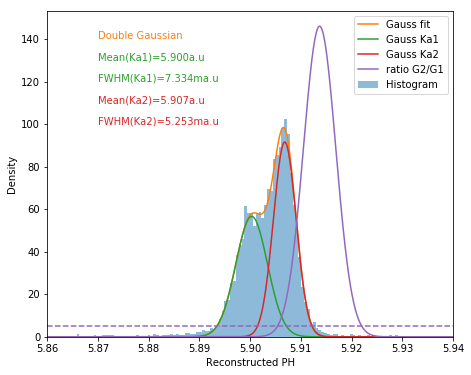

In [21]:
nbinsKas = 200
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1, 2, 1)
# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple rows)
dataKas_HR = dataKas_HR[dataKas_HR.SIGNAL>5.80]
dataKas_HR = dataKas_HR[dataKas_HR.SIGNAL<5.95]

# create histogram
#ax1 = dataKas_HR.SIGNAL.plot.hist(bins=200, density=True, label="Histogram")
bin_heights, bin_borders, _ = ax1.hist(dataKas_HR.SIGNAL, bins=nbinsKas, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

# fit two gaussians to density-histogram (also "curve_fit" ?)
gg_init = (models.Gaussian1D(amplitude=56, mean=5.89, stddev=0.005) +
           models.Gaussian1D(amplitude=90, mean=5.90, stddev=0.005))
#fitter = fitting.SLSQPLSQFitter()
fitter = fitting.LevMarLSQFitter()
gg_fit = fitter(gg_init, bin_centers, bin_heights)

#C1 = gg_fit.param_sets[0][0]
#mean1 = gg_fit.param_sets[1][0] #u.a.
#sigma1 = gg_fit.param_sets[2][0] #u.a.
#C2 = gg_fit.param_sets[3][0] 
#mean2 = gg_fit.param_sets[4][0] #u.a.
#sigma2 = gg_fit.param_sets[5][0] #u.a.

C1 = gg_fit.amplitude_0[0]
mean1 = gg_fit.mean_0[0]
sigma1 = gg_fit.stddev_0[0]
fwhm1 = sigma1 *1000.* 2*np.sqrt(2*np.log(2)) #mu.a.
C2 = gg_fit.amplitude_1[0]
mean2 = gg_fit.mean_1[0]
sigma2 = gg_fit.stddev_1[0]
fwhm2 = sigma2 * 1000. * 2*np.sqrt(2*np.log(2)) #mu.a.
#gg_fit.fit_info['residuals']
g1 = models.Gaussian1D(amplitude=C1, mean=mean1, stddev=sigma1)
g2 = models.Gaussian1D(amplitude=C2, mean=mean2, stddev=sigma2)
ratioGG = g2(x_interval_for_fit)/g1(x_interval_for_fit)

# plot histogram and Gaussians fit
ax1.plot(x_interval_for_fit, gg_fit(x_interval_for_fit), label='Gauss fit')
ax1.plot(x_interval_for_fit, g1(x_interval_for_fit), label="Gauss Ka1")
ax1.plot(x_interval_for_fit, g2(x_interval_for_fit), label="Gauss Ka2")
ax1.plot(x_interval_for_fit, ratioGG, label="ratio G2/G1")
ax1.axhline(ratio,linestyle='--', color='tab:purple')
ax1.text(5.87,140, "Double Gaussian", color='tab:orange')
ax1.text(5.87,130, "Mean(Ka1)=" + '{:0.3f}'.format(mean1) + "a.u", color='tab:green')
ax1.text(5.87,120, "FWHM(Ka1)=" + '{:0.3f}'.format(fwhm1) + "ma.u", color='tab:green')
ax1.text(5.87,110, "Mean(Ka2)=" + '{:0.3f}'.format(mean2) + "a.u", color='tab:red')
ax1.text(5.87,100, "FWHM(Ka2)=" + '{:0.3f}'.format(fwhm2) + "ma.u", color='tab:red')
ax1.set_xlabel("Reconstructed PH")
ax1.set_ylabel("Density")
ax1.set_xlim(5.86, 5.94)
plt.legend()
plt.show()

### 2.3.2 Select PH_ID of (non)Ka2 pulses

In [22]:
PHmin = x_interval_for_fit[ratioGG >= ratio][0]
PHmax = x_interval_for_fit[ratioGG >= ratio][-1]
print("Ka2 PHs in [" + '{:0.3f}'.format(PHmin) + "," + '{:0.3f}'.format(PHmax) + "] a.u.")

#select PH_IDs for Ka2 (in [PHmin,PHmax] interval)
dataKa2 = dataKas_HR[dataKas_HR.SIGNAL >= PHmin]
dataKa2 = dataKa2[dataKa2.SIGNAL <= PHmax]
PH_ID_Ka2 = dataKa2.PH_ID.to_list()
PH_ID_Ka2_single = set(PH_ID_Ka2).intersection(dataKas_single_PH_ID) # good Ka2 pulses

#select PH_IDs to exclude Ka2 in single-pulse records
PH_ID_noKa2 = list(set(dataKas.PH_ID.to_list()).difference(PH_ID_Ka2_single))
print("Number of non-Ka2-single pulses:", len(PH_ID_noKa2))

Ka2 PHs in [5.905,5.922] a.u.
Number of non-Ka2-single pulses: 7528


### 2.4.3 Extract Ka2 pulses to build a new library

In [ ]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    nphs = len(PH_ID_noKa2)
    # first iteration
    expr = "'PH_ID != " + str(PH_ID_noKa2[0]) + "'"
    comm = ("fselect infile=" + fileph_Kas + "+8 outfile=" + fileph_Ka2 + " clobber=yes expr=" + expr)
    try:
        print("Selecting Ka2 pulses")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting Ka2 pulses with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    # other non-selections follow
    iph = 1
    while iph < nphs:
        expr = "'"
        iiph = 1
        while (iiph < 20 and iph < nphs):
            expr = expr + "PH_ID != " + str(PH_ID_noKa2[iph]) + " && "
            iiph += 1
            iph  += 1

        expr = expr + "PH_ID != " + str(PH_ID_noKa2[iph]) + "'"
        iph += 1
        comm = ("fselect infile=" + fileph_Ka2 + "+8 outfile=" + tmpFile + " clobber=yes expr=" + expr)
        try:
            print("Selecting Ka2 pulses")
            print("iph=" + str(iph) + "/" + str(nphs))
            print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error Selecting Ka2 pulses with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise

        shutil.copy(tmpFile, fileph_Ka2)
        os.remove(tmpFile)
        
    print("Finshed selection of Ka2 events")

## 2.3 Build the new library of Ka2 pulses

In [ ]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    comm = ("tesreconstruction Recordfile=" + fileph_Ka2 + " TesEventFile=" + tmpFile + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=0 OFLib=yes FilterDomain=F " + 
            " detectionMode=STC detectSP=1 FilterMethod=" + F0orB0 + " clobber=yes EventListSize=1000" + 
            " EnergyMethod=" + method + " LagsOrNot=1 tstartPulse1=0 tstartPulse2=0 OFNoise=NSD " + 
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " NoiseFile=" + noisefile +
            " monoenergy=" + str(Ka2eV) + " preBuffer=" + str(preBuffer))
    try:
        print("Building initial library (Kas)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Building initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    os.remove(tmpFile)

## 3. Reconstruct all pulses with new Ka2 library

In [ ]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph + " TesEventFile=" + evt_libKa2 + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ library (Ka2)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Ka2) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evt_libKa2 + " outfile=" + evt_libKa2_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR Kas & Kb evts")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas & Kb evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

## 4. Calibrate data fitting 2 Gaussians

### 4.1 Read HR pulses

In [25]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evt_libKa2_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
data_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of initial (all energies) HR pulses:", len(data_HR))    


FDUMPing evt file
Number of initial (all energies) HR pulses: 13758


### 4.2 Fit 2 gaussians to Kas and 1 gaussian to Kb

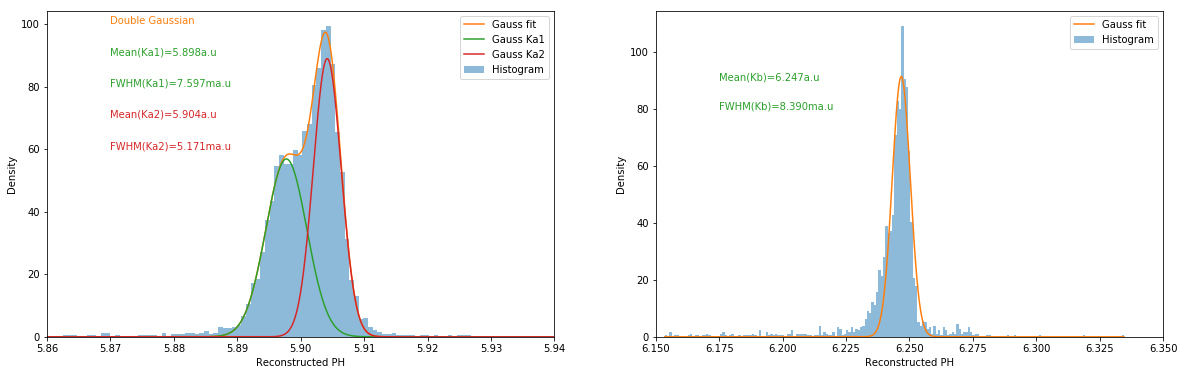

In [28]:
nbinsKas = 200
nbinsKb = 200
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1, 2, 1)
# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple rows)
dataKas_HR = data_HR[data_HR.SIGNAL>5.80]
dataKas_HR = dataKas_HR[dataKas_HR.SIGNAL<5.95]

# create histogram
#ax1 = dataKas_HR.SIGNAL.plot.hist(bins=200, density=True, label="Histogram")
bin_heights, bin_borders, _ = ax1.hist(dataKas_HR.SIGNAL,bins=nbinsKas, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

# fit two gaussians to density-histogram (also "curve_fit" ?)
gg_init = (models.Gaussian1D(amplitude=56, mean=5.89, stddev=0.005) + 
           models.Gaussian1D(amplitude=90, mean=5.90, stddev=0.005))
#fitter = fitting.SLSQPLSQFitter()
fitter = fitting.LevMarLSQFitter()
gg_fit = fitter(gg_init, bin_centers, bin_heights)

C1 = gg_fit.amplitude_0[0]
mean1 = gg_fit.mean_0[0]
sigma1 = gg_fit.stddev_0[0]
fwhm1 = sigma1 *1000.* 2*np.sqrt(2*np.log(2)) #mu.a.
C2 = gg_fit.amplitude_1[0]
mean2 = gg_fit.mean_1[0]
sigma2 = gg_fit.stddev_1[0]
fwhm2 = sigma2 * 1000. * 2*np.sqrt(2*np.log(2)) #mu.a.
g1 = models.Gaussian1D(amplitude=C1, mean=mean1, stddev=sigma1)
g2 = models.Gaussian1D(amplitude=C2, mean=mean2, stddev=sigma2)

# plot histogram and 2 Gaussians fit
ax1.plot(x_interval_for_fit, gg_fit(x_interval_for_fit), label='Gauss fit')
ax1.plot(x_interval_for_fit, g1(x_interval_for_fit), label="Gauss Ka1")
ax1.plot(x_interval_for_fit, g2(x_interval_for_fit), label="Gauss Ka2")
ax1.text(5.87,100, "Double Gaussian", color='tab:orange')
ax1.text(5.87,90, "Mean(Ka1)=" + '{:0.3f}'.format(mean1) + "a.u", color='tab:green')
ax1.text(5.87,80, "FWHM(Ka1)=" + '{:0.3f}'.format(fwhm1) + "ma.u", color='tab:green')
ax1.text(5.87,70, "Mean(Ka2)=" + '{:0.3f}'.format(mean2) + "a.u", color='tab:red')
ax1.text(5.87,60, "FWHM(Ka2)=" + '{:0.3f}'.format(fwhm2) + "ma.u", color='tab:red')
ax1.set_xlabel("Reconstructed PH")
ax1.set_ylabel("Density")
ax1.set_xlim(5.86, 5.94)
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
# select data in Kb range
dataKb_HR = data_HR[data_HR.SIGNAL>6.15]
dataKb_HR = dataKb_HR[dataKb_HR.SIGNAL<6.35]

# create histogram
bin_heights, bin_borders, _ = ax2.hist(dataKb_HR.SIGNAL,bins=nbinsKb, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

# fit 1 gaussian to density-histogram (also "curve_fit" ?)
g_init = models.Gaussian1D(56, 6.25, 0.005) 
fitter = fitting.LevMarLSQFitter()
g_fit = fitter(g_init, bin_centers, bin_heights)

C3 = g_fit.amplitude[0]
mean3 = g_fit.mean[0]
sigma3 = g_fit.stddev[0]
fwhm3 = sigma3 *1000.* 2*np.sqrt(2*np.log(2)) #mu.a.

# plot histogram and Gaussians fit
ax2.plot(x_interval_for_fit, g_fit(x_interval_for_fit), label='Gauss fit')
ax2.text(6.175,90, "Mean(Kb)=" + '{:0.3f}'.format(mean3) + "a.u", color='tab:green')
ax2.text(6.175,80, "FWHM(Kb)=" + '{:0.3f}'.format(fwhm3) + "ma.u", color='tab:green')
ax2.set_xlabel("Reconstructed PH")
ax2.set_ylabel("Density")
ax2.set_xlim(6.15, 6.35)
ax2.legend()

### 4.3 Create gain scale

In [29]:
lines = (Ka1keV, Ka2keV, KbkeV)
recon_lines = (mean1,mean2,mean3)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept    
    ------------------ -----------------
    1.7270732309122954 -4.29819006720991


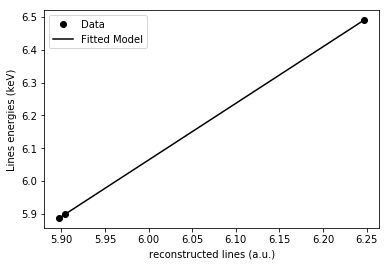

In [31]:
# define a model for a line
line_orig = models.Linear1D(slope=1.0, intercept=0.5)
# initialize a linear fitter
fit = fitting.LinearLSQFitter()
# initialize a linear model
line_init = models.Linear1D()

# fit the data with the fitter
fitted_line = fit(line_init, recon_lines, lines)
print(fitted_line)
slope = fitted_line.slope[0]
inter = fitted_line.intercept[0]

# plot the model
plt.figure()
plt.plot(recon_lines, lines, 'ko', label='Data')
plt.plot(recon_lines, fitted_line(recon_lines), 'k-', label='Fitted Model')
plt.xlabel('reconstructed lines (a.u.)')
plt.ylabel('Lines energies (keV)')
plt.legend()

### 4.4 Calibrate energies

Text(0,0.5,'Density')

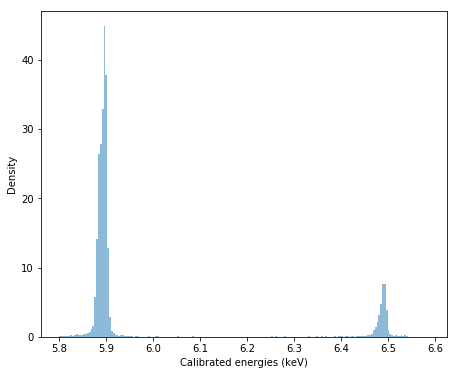

In [33]:
eners_HR = inter + slope * data_HR.SIGNAL
# select data in Kas/Kb range (otherwise there is always a smaller pulse comimg from multiple rows)
enerKs_HR = eners_HR[eners_HR > 5.80]
enerKs_HR = enerKs_HR[enerKs_HR < 6.6]

# create histogram
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1, 2, 1)
bin_heights, bin_borders, _ = ax1.hist(enerKs_HR,bins=200, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
ax1.set_xlabel("Calibrated energies (keV)")
ax1.set_ylabel("Density")


## 5. Get FWHM of Kas lines fitting Voigt profiles

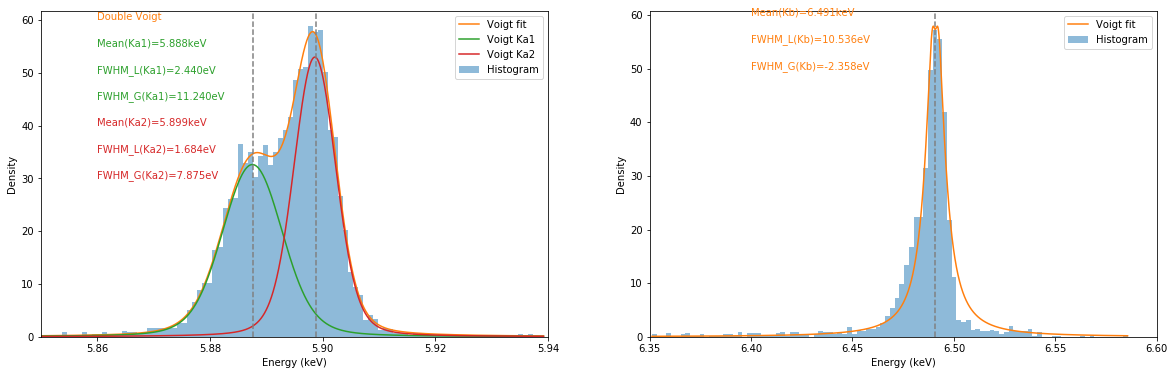

In [38]:
nbinsKas = 100
nbinsKb = 100
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1, 2, 1)
# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple rows)
# select data in Kas/Kb range (otherwise there is always a smaller pulse comimg from multiple rows)
enerKas_HR = eners_HR[eners_HR > 5.85]
enerKas_HR = enerKas_HR[enerKas_HR < 5.94]

# create histogram
bin_heights, bin_borders, _ = ax1.hist(enerKas_HR,bins=nbinsKas, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
#print("bin centers=", bin_centers)

# fit two gaussians to density-histogram (also "curve_fit" ?)
vv_init = (models.Voigt1D(x_0=Ka1keV, amplitude_L=50, fwhm_L=0.005, fwhm_G=0.002) + 
           models.Voigt1D(x_0=Ka2keV, amplitude_L=70, fwhm_L=0.005, fwhm_G=0.002)) 
fitter = fitting.LevMarLSQFitter()
vv_fit = fitter(vv_init, bin_centers, bin_heights)

amp1 = vv_fit.amplitude_L_0[0]
center1 = vv_fit.x_0_0[0]
fwhm_L1 = vv_fit.fwhm_L_0[0]
fwhm_G1 = vv_fit.fwhm_G_0[0]
amp2 = vv_fit.amplitude_L_1[0]
center2 = vv_fit.x_0_1[0]
fwhm_L2 = vv_fit.fwhm_L_1[0]
fwhm_G2 = vv_fit.fwhm_G_1[0]

v1 = models.Voigt1D(x_0=center1, amplitude_L=amp1, fwhm_L=fwhm_L1, fwhm_G=fwhm_G1) 
v2 = models.Voigt1D(x_0=center2, amplitude_L=amp2, fwhm_L=fwhm_L2, fwhm_G=fwhm_G2) 

# plot histogram and 2 Voigt fit
ax1.plot(x_interval_for_fit, vv_fit(x_interval_for_fit), label='Voigt fit')
ax1.plot(x_interval_for_fit, v1(x_interval_for_fit), label="Voigt Ka1")
ax1.plot(x_interval_for_fit, v2(x_interval_for_fit), label="Voigt Ka2")
ax1.text(5.86,60, "Double Voigt", color='tab:orange')
ax1.text(5.86,55, "Mean(Ka1)=" + '{:0.3f}'.format(center1) + "keV", color='tab:green')
ax1.text(5.86,50, "FWHM_L(Ka1)=" + '{:0.3f}'.format(fwhm_L1*1e3) + "eV", color='tab:green')
ax1.text(5.86,45, "FWHM_G(Ka1)=" + '{:0.3f}'.format(fwhm_G1*1e3) + "eV", color='tab:green')
ax1.text(5.86,40, "Mean(Ka2)=" + '{:0.3f}'.format(center2) + "keV", color='tab:red')
ax1.text(5.86,35, "FWHM_L(Ka2)=" + '{:0.3f}'.format(fwhm_L2*1e3) + "eV", color='tab:red')
ax1.text(5.86,30, "FWHM_G(Ka2)=" + '{:0.3f}'.format(fwhm_G2*1e3) + "eV", color='tab:red')
ax1.axvline(Ka1keV,linestyle='--', color='gray')
ax1.axvline(Ka2keV,linestyle='--', color='gray')
ax1.set_xlabel("Energy (keV)")
ax1.set_ylabel("Density")
ax1.set_xlim(5.85, 5.94)
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
# select data in Kb range
enerKb_HR = eners_HR[eners_HR>6.35]
enerKb_HR = enerKb_HR[enerKb_HR<6.6]

# create histogram
bin_heights, bin_borders, _ = ax2.hist(enerKb_HR,bins=nbinsKb, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

# fit 1 gaussian to density-histogram (also "curve_fit" ?)
v_init = models.Voigt1D(x_0=KbkeV, amplitude_L=10, fwhm_L=0.005, fwhm_G=0.002) 
fitter = fitting.LevMarLSQFitter()
v_fit = fitter(v_init, bin_centers, bin_heights)

amp3 = v_fit.amplitude_L[0]
center3 = v_fit.x_0[0]
fwhm_L3 = v_fit.fwhm_L[0]
fwhm_G3 = v_fit.fwhm_G[0]
ax2.axvline(KbkeV,linestyle='--', color='gray')

# plot histogram and Voigt fit
ax2.plot(x_interval_for_fit, v_fit(x_interval_for_fit), label='Voigt fit',color='tab:orange')
ax2.text(6.4,60, "Mean(Kb)=" + '{:0.3f}'.format(center3) + "keV", color='tab:orange')
ax2.text(6.4,55, "FWHM_L(Kb)=" + '{:0.3f}'.format(fwhm_L3*1e3) + "eV", color='tab:orange')
ax2.text(6.4,50, "FWHM_G(Kb)=" + '{:0.3f}'.format(fwhm_G3*1e3) + "eV", color='tab:orange')
ax2.set_xlabel("Energy (keV)")
ax2.set_ylabel("Density")
ax2.set_xlim(6.35, 6.6)
ax2.legend()